<a href="https://colab.research.google.com/github/AdityaPunetha/ML-Projects/blob/main/TensorFlow-Fashion-MNIST-GAN/improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
from numpy.random import randint, randn
from numpy import zeros, ones
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Reshape,
    LeakyReLU,
    Dropout,
    Conv2DTranspose,
    ReLU,
)
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os

%matplotlib inline

# Load Data

In [2]:
(trainX, trainy), (testX, testy) = load_data()
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


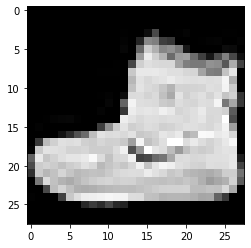

In [3]:
plt.imshow(trainX[0], cmap="gray")

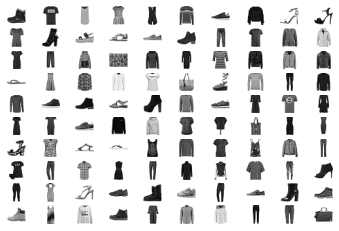

In [4]:
for i in range(100):
    plt.subplot(10, 10, 1 + i)
    plt.axis("off")
    plt.imshow(trainX[i], cmap="gray_r")
plt.show()

In [5]:
in_shape = (28, 28, 1)

# Build Discriminator

In [6]:
discriminator = Sequential()

# First Conv Block
discriminator.add(
    Conv2D(128, (3, 3), strides=(2, 2), padding="same", input_shape=in_shape)
)
discriminator.add(LeakyReLU(0.2))

# Second Conv Block
discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
discriminator.add(LeakyReLU(0.2))

# Flatten then pass to dense layer
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation="sigmoid"))

In [7]:
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"],
)

In [8]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

# Define Generator

In [9]:
latent_size = 128

In [10]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_dim=latent_size))
generator.add(ReLU())
generator.add(Reshape((7, 7, 128)))

# Upsampling block 1
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
generator.add(ReLU())

# Upsampling block 2
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
generator.add(ReLU())

# Conv layer to get to one channel
generator.add(Conv2D(1, (7, 7), activation="tanh", padding="same"))

In [11]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

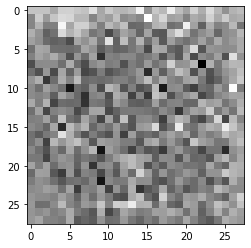

In [12]:
sample_generated_image = generator(randn(1, latent_size))
plt.imshow(np.squeeze(sample_generated_image[0]), cmap="gray")

# Define GAN

In [13]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

# Train discriminator

In [14]:
batch_size = 256

In [15]:
X = np.expand_dims(trainX, axis=-1)
X = X.astype("float32")
X = (X - 127.5) / 127.5

In [16]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    return x

In [17]:
def train_discriminator(images):
    real_labels = ones((batch_size, 1))
    fake_labels = zeros((batch_size, 1))

    d_loss_real, _ = discriminator.train_on_batch(images, real_labels)

    generated_images = generator(randn(batch_size, latent_size))

    d_loss_fake, _ = discriminator.train_on_batch(generated_images, fake_labels)

    d_loss = d_loss_fake + d_loss_real

    return d_loss, d_loss_fake, d_loss_real

# Training the model

In [18]:
gan_model = define_gan(generator, discriminator)

In [19]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1339905   
                                                                 
 sequential (Sequential)     (None, 1)                 155137    
                                                                 
Total params: 1,495,042
Trainable params: 1,339,905
Non-trainable params: 155,137
_________________________________________________________________


In [20]:
bat_per_epo = int(X.shape[0] / batch_size)

In [21]:
num_epochs = 100
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i in range(bat_per_epo):
        X_real = generate_real_samples(X, batch_size)

        d_loss, d_loss_fake, d_loss_real = train_discriminator(X_real)

        g_loss = gan_model.train_on_batch(
            randn(batch_size, latent_size), ones((batch_size, 1))
        )

        if (i + 1) % 200 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}".format(
                    epoch, num_epochs, i + 1, bat_per_epo, d_loss, g_loss
                )
            )

Epoch [0/100], Step [200/234], d_loss: 1.2006, g_loss: 1.1217
Epoch [1/100], Step [200/234], d_loss: 1.4997, g_loss: 0.7105
Epoch [2/100], Step [200/234], d_loss: 1.3611, g_loss: 0.7771
Epoch [3/100], Step [200/234], d_loss: 1.3841, g_loss: 0.7088
Epoch [4/100], Step [200/234], d_loss: 1.3076, g_loss: 0.7874
Epoch [5/100], Step [200/234], d_loss: 1.3430, g_loss: 0.7156
Epoch [6/100], Step [200/234], d_loss: 1.3278, g_loss: 0.8202
Epoch [7/100], Step [200/234], d_loss: 1.3500, g_loss: 0.7226
Epoch [8/100], Step [200/234], d_loss: 1.3349, g_loss: 0.7317
Epoch [9/100], Step [200/234], d_loss: 1.3273, g_loss: 0.8341
Epoch [10/100], Step [200/234], d_loss: 1.4330, g_loss: 0.6942
Epoch [11/100], Step [200/234], d_loss: 1.2686, g_loss: 0.7894
Epoch [12/100], Step [200/234], d_loss: 1.3619, g_loss: 0.7965
Epoch [13/100], Step [200/234], d_loss: 1.3862, g_loss: 0.7273
Epoch [14/100], Step [200/234], d_loss: 1.3652, g_loss: 0.7491
Epoch [15/100], Step [200/234], d_loss: 1.3825, g_loss: 0.7304
Ep

# Post training

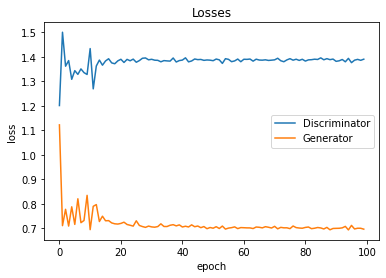

In [24]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

In [35]:
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis("off")
        plt.imshow(np.squeeze(examples[i, :, :, :]), cmap="gray")
    plt.show()

In [33]:
trained_generator_sample_images = generator.predict(randn(25, latent_size))

In [28]:
trained_generator_sample_images = (trained_generator_sample_images + 1) / 2.0

In [29]:
trained_generator_sample_images = (trained_generator_sample_images * 255).astype(
    np.uint8
)

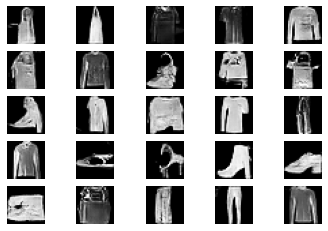

In [36]:
show_plot(trained_generator_sample_images, 5)

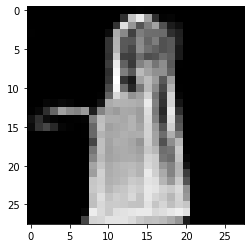

In [37]:
plt.imshow(np.squeeze(trained_generator_sample_images[0]), cmap="gray")

In [22]:
tf.saved_model.save(generator, "generator_improved")

INFO:tensorflow:Assets written to: generator_improved/assets


In [23]:
!zip -r /content/generator_improved.zip /content/generator_improved

  adding: content/generator_improved/ (stored 0%)
  adding: content/generator_improved/variables/ (stored 0%)
  adding: content/generator_improved/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/generator_improved/variables/variables.index (deflated 52%)
  adding: content/generator_improved/assets/ (stored 0%)
  adding: content/generator_improved/saved_model.pb (deflated 89%)
